In [57]:
import networkx as nx
import pandas as pd
from tqdm import tqdm
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import scipy
from random import sample
import csv
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import pickle

In [ ]:
def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

# Data loading and processing

In [2]:
Data = open('edge.csv', "r")
# next(Data, None)  # skip the first line in the input file
Graphtype = nx.Graph()

G = nx.parse_edgelist(Data, delimiter=',', create_using=Graphtype,
                      nodetype=int) #, data=(('weight', float),))

In [11]:
with open('edge.csv', newline='') as f:
    reader = csv.reader(f)
    edges = list(reader)

In [17]:
pos_edge_df = pd.DataFrame()
node_1 = []
node_2 = []

for edge in tqdm(edges):
    node_1.append(int(edge[0]))
    node_2.append(int(edge[1]))
    
pos_edge_df['node_1'] = node_1
pos_edge_df['node_2'] = node_2

100%|████████████████████████████████████████████████████████████████████| 1067911/1067911 [00:01<00:00, 807965.79it/s]


In [4]:
G_complement = nx.complement(G)

In [7]:
negative_edges = sample(list(G_complement.edges()),len(edges)) 

In [19]:
neg_edge_df = pd.DataFrame()
node_1 = []
node_2 = []

for edge in tqdm(negative_edges):
    node_1.append(int(edge[0]))
    node_2.append(int(edge[1]))
    
neg_edge_df['node_1'] = node_1
neg_edge_df['node_2'] = node_2

100%|████████████████████████████████████████████████████████████████████| 1067910/1067910 [00:01<00:00, 622344.95it/s]


In [20]:
all_data = pd.concat([pos_edge_df,neg_edge_df])
all_data['Y'] = [1] * len(pos_edge_df) + [0] * len(neg_edge_df)

In [22]:
all_data.tail()

,node_1,node_2,Y
1067905,2688,4218,0
1067906,3190,1754,0
1067907,949,2454,0
1067908,3925,4119,0
1067909,2961,1928,0


In [23]:
n2v_embeddings = np.load('n2v_emb.npy')

In [24]:
n2v_embeddings.shape

(4267, 128)

# Train-test

In [26]:
train_pos, test_pos = train_test_split(pos_edge_df, test_size=0.2)
train_neg, test_neg = train_test_split(neg_edge_df, test_size=0.2)

In [29]:
all_train = pd.concat([train_pos,train_neg])
all_train['Y'] = [1] * len(train_pos) + [0] * len(train_neg)

In [30]:
node1_concat_node2_emb = []

for index, row in tqdm(all_train.iterrows()):
    node1_concat_node2_emb.append(list(n2v_embeddings[row['node_1']]) + list(n2v_embeddings[row['node_2']]))
    
all_train['edge_embed'] = node1_concat_node2_emb

1708656it [07:04, 4023.33it/s]


In [32]:
all_test = pd.concat([test_pos,test_neg])
all_test['Y'] = [1] * len(test_pos) + [0] * len(test_neg)

In [33]:
node1_concat_node2_emb = []

for index, row in tqdm(all_test.iterrows()):
    node1_concat_node2_emb.append(list(n2v_embeddings[row['node_1']]) + list(n2v_embeddings[row['node_2']]))
    
all_test['edge_embed'] = node1_concat_node2_emb

427165it [02:08, 3330.67it/s]


In [36]:
clf = MLPClassifier(hidden_layer_sizes=(3,256),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01,
                    max_iter=100)

In [37]:
X_train = all_train['edge_embed'].tolist()
y_train = all_train['Y'].tolist()
clf.fit(X_train,y_train)

Iteration 1, loss = 0.27821718
Iteration 2, loss = 0.27064691
Iteration 3, loss = 0.26959330
Iteration 4, loss = 0.26912137
Iteration 5, loss = 0.26883527
Iteration 6, loss = 0.26875873
Iteration 7, loss = 0.26867704
Iteration 8, loss = 0.26859496
Iteration 9, loss = 0.26852764
Iteration 10, loss = 0.26851655
Iteration 11, loss = 0.26851216
Iteration 12, loss = 0.26836811
Iteration 13, loss = 0.26829960
Iteration 14, loss = 0.26840892
Iteration 15, loss = 0.26836210
Iteration 16, loss = 0.26837240
Iteration 17, loss = 0.26828808
Iteration 18, loss = 0.26822901
Iteration 19, loss = 0.26824533
Iteration 20, loss = 0.26839111
Iteration 21, loss = 0.26826384
Iteration 22, loss = 0.26825588
Iteration 23, loss = 0.26831983
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 256), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=5, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [41]:
X_test = all_test['edge_embed'].tolist()
ypred = clf.predict(X_test)

In [42]:
all_test['pred'] = ypred

In [66]:
all_train.to_csv('all_train.csv')
all_test.to_csv('all_test.csv')

# Degree binning perfromance

In [46]:
with open('degree_bins_ddi.pkl', 'rb') as handle:
    bin_dict = pickle.load(handle)

In [48]:
bin_1_nodes = bin_dict['bin_1']
bin_2_nodes = bin_dict['bin_2']
bin_3_nodes = bin_dict['bin_3']

In [49]:
all_test_bin_1 = all_test[all_test['node_1'].isin(bin_1_nodes) & all_test['node_2'].isin(bin_1_nodes)]
print(len(all_test_bin_1))

13975


In [53]:
print('AUROC: ', roc_auc_score(all_test_bin_1['Y'].tolist(),all_test_bin_1['pred'].tolist()))
print('AUPRC: ', average_precision_score(all_test_bin_1['Y'].tolist(),all_test_bin_1['pred'].tolist()))

AUROC:  0.5
AUPRC:  0.009516994633273703


In [50]:
all_test_bin_2 = all_test[all_test['node_1'].isin(bin_2_nodes) & all_test['node_2'].isin(bin_2_nodes)]
print(len(all_test_bin_2))

171114


In [54]:
print('AUROC: ', roc_auc_score(all_test_bin_2['Y'].tolist(),all_test_bin_2['pred'].tolist()))
print('AUPRC: ', average_precision_score(all_test_bin_2['Y'].tolist(),all_test_bin_2['pred'].tolist()))

AUROC:  0.8516938454234002
AUPRC:  0.803759941642833


In [51]:
all_test_bin_3 = all_test[all_test['node_1'].isin(bin_3_nodes) & all_test['node_2'].isin(bin_3_nodes)]
print(len(all_test_bin_3))

25117


In [55]:
print('AUROC: ', roc_auc_score(all_test_bin_3['Y'].tolist(),all_test_bin_3['pred'].tolist()))
print('AUPRC: ', average_precision_score(all_test_bin_3['Y'].tolist(),all_test_bin_3['pred'].tolist()))

AUROC:  0.5326928310561292
AUPRC:  0.9531479159173118


In [56]:
all_test_bind_2_3 = pd.concat([all_test_bin_2,all_test_bin_3])
print('AUROC: ', roc_auc_score(all_test_bind_2_3['Y'].tolist(),all_test_bind_2_3['pred'].tolist()))
print('AUPRC: ', average_precision_score(all_test_bind_2_3['Y'].tolist(),all_test_bind_2_3['pred'].tolist()))

AUROC:  0.8585328446872779
AUPRC:  0.8383357016983317


# Plot

C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


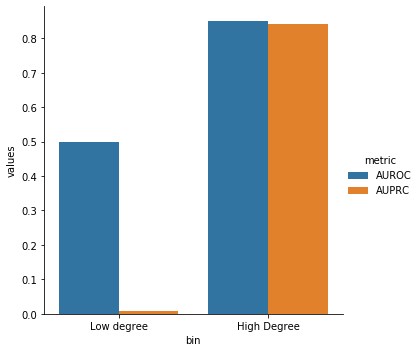

In [65]:
df = pd.DataFrame()
df['bin'] = ['Low degree'] * 2 + ['High Degree'] * 2 
df['metric'] = ['AUROC', 'AUPRC'] * 2
df['values'] = [0.5, 0.009, 0.85, 0.84] 
#figure(figsize=(8, 8),dpi=300)
sns.factorplot(x='bin', y='values', hue='metric', data=df, kind='bar')
#figure.savefig('bin_perf.png' % ind, dpi=300)